In [46]:
%matplotlib inline 
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm

In [142]:
def create_blist(alist):
    nodes = len(alist);
    deg = np.sum(alist);
    blist = (deg/int(nodes)) * np.ones((nodes));
    while deg>np.sum(blist):
        r = np.random.randint(0,nodes);
        blist[r]+=1;
    while deg<np.sum(blist):
        r = np.random.randint(0,nodes);
        blist[r]-=1;
    if deg==np.sum(blist):
        return map(int,blist)
#     else:
#         continue;#print('Fail')

In [143]:
def create_ER_bipartite_graph(N,p):
    g = nx.erdos_renyi_graph(N,p);
    alist = list(dict(nx.degree(g)).values());
    blist = create_blist(alist);
    return nx.bipartite.configuration_model(list(alist),list(alist),seed=int(time.time()));

In [144]:
from scipy.special import binom


In [145]:
def layer_probability_not_interference(nk, k1, k2):
#     return binom(nk, k1) * binom(nk - k1, k2) / binom(nk, k2);
    return binom(nk - k1, k2) / binom(nk, k2);

def layer_interference_check(g, i, j):
    bip = nx.get_node_attributes(g, 'bipartite');
    if bip[i] != bip[j]:
        print('nodes in different layers')
        return None;
    intersect = set(g.neighbors(i)).intersection(set(g.neighbors(j)))
    if len(intersect)>0:
        return True;
    else:
        return False;

In [146]:
np.random.randint(0, 10, (1,2))

array([[2, 0]])

In [233]:
import time
num_nodes = 20
conn_prob = .2
G = create_ER_bipartite_graph(num_nodes,conn_prob);
while not nx.is_connected(G):
    G = create_ER_bipartite_graph(num_nodes,conn_prob)

relabel_dict = dict(zip(list(G.nodes()), range(G.number_of_nodes())))
G = nx.relabel_nodes(G, relabel_dict)

In [234]:
zero_layer = [n[0] for n in list(G.nodes(data=True)) if n[1]['bipartite'] == 0]
pos = nx.bipartite_layout(G, zero_layer)

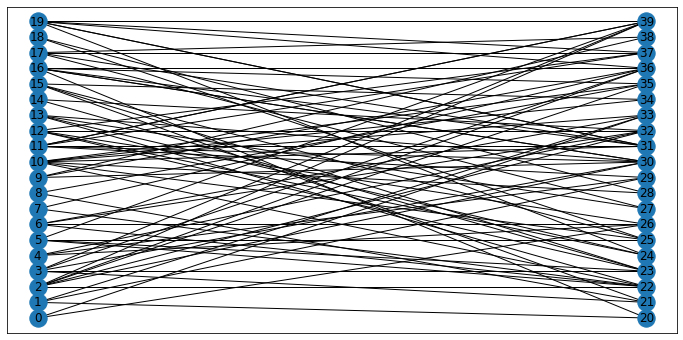

In [235]:
fig = plt.figure(figsize=(12,6))
nx.draw_networkx(G, pos)

In [284]:
# first attempt to check whether this calculation makes any sense... 
from itertools import combinations 
interference_results = {'no-interference': [], 'interference': []}
deg = dict(G.degree())
interference_count = 0
combs = np.array(list(combinations(zero_layer,2)))
# combs = combs[np.random.choice(range(len(combs)), 50, replace=False)]
for n, nn in combs:
    k1, k2 = deg[n], deg[nn]
    prob = layer_probability_not_interference(20, k1, k2);
    if layer_interference_check(G, n, nn)==True:
        interference_count+=1
        interference_results['interference'].append(prob);
    else:
        interference_results['no-interference'].append(prob);

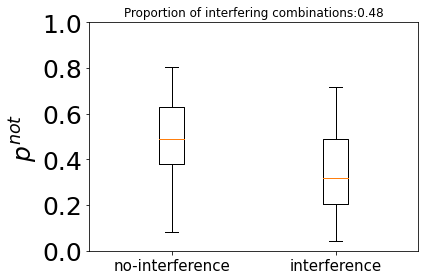

In [290]:
plt.boxplot(interference_results.values(), labels=interference_results.keys());
plt.xticks(fontsize=15)
# plt.title('probability of no-interference', fontsize=25)
plt.ylabel(r'$p^{not}$', fontsize=25)
plt.yticks(fontsize=25)

plt.ylim(0,1)
plt.title('Proportion of interfering combinations:'+str(round(interference_count/binom(len(zero_layer),2),2)))
plt.tight_layout()
plt.savefig('../../white-paper/plots/single-layer-degree-prediction.pdf')

In [220]:
num_nodes = 20

def create_ER_deep_network(num_units, num_layers, p_conn):
    DN = {}
    for l in range(num_layers):
        G = create_ER_bipartite_graph(num_nodes,0.1);
        while not nx.is_connected(G):
            G = create_ER_bipartite_graph(num_nodes,0.1)
        relabel_dict = dict(zip(list(G.nodes()), range(G.number_of_nodes())))
        G = nx.relabel_nodes(G, relabel_dict)
        DN[l] = G.copy();
        del G;
    return DN

In [153]:
def create_task_path(DN, initial_node):
    task_path, task_degree_path = [], []
    for l in DN:
        if l==0:
            task_path.append(initial_node);
        task_degree_path.append(DN[l].degree(task_path[-1]))
        
        candidates = list(DN[l].neighbors(task_path[-1]));
        target_node = np.random.choice(candidates,1)[0]
        task_path.append(target_node - num_nodes);
    return task_path, task_degree_path;

In [297]:
def check_task_path_interference(p1, p2):
#      if p1[0]==p2[0]:
#         return np.nan; #paths start at the same point so we should not consider them
    if np.any(np.array(p1) == np.array(p2)):
        return True; #paths interfere
    else:
        return False; #paths do not interfere
    
def compound_not_interference_probability(ds1, ds2, num_nodes):
    p = [];
    for x in range(len(ds1)):
        p.append(layer_probability_not_interference(num_nodes, ds1[x], ds2[x]));
    return np.prod(p);


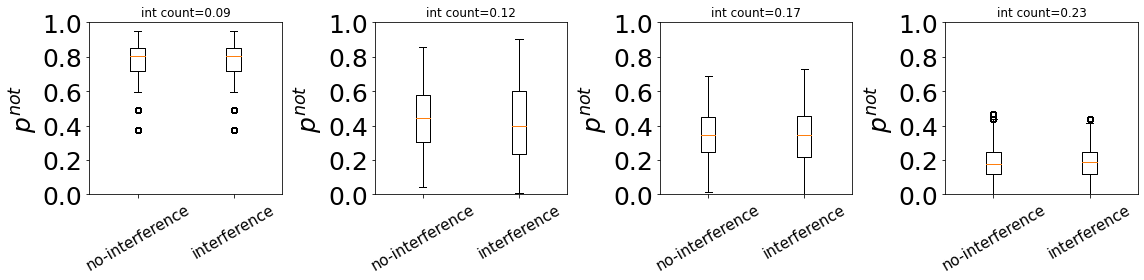

In [299]:
fig = plt.figure(figsize=(16,4))

conn_prob = 0.1
num_paths_base = 20;
num_nodes = 20;

dn = {}
for L in tqdm(range(1,5)):
    plt.subplot(1, 4, L)
    dn[L] = create_ER_deep_network(num_nodes, L, conn_prob)
    paths_set = []
    num_paths = num_paths_base*L*20
    for i in range(num_paths):
        paths_set.append(create_task_path(dn[L], np.random.randint(num_nodes)))
    interference_count = 0
    dn_interference_results = {'no-interference': [], 'interference': []}
    for cp1, cp2 in combinations(paths_set,2):
        p1, p2 = cp1[0], cp2[0];
        ds1, ds2 = cp1[1], cp2[1];
        check_int = check_task_path_interference(p1, p2);
        prob = compound_not_interference_probability(ds1, ds2, num_nodes);
        if check_int==True:
            interference_count+=1;
            dn_interference_results['interference'].append(prob);
        elif check_int==False:
            dn_interference_results['no-interference'].append(prob);
    
    plt.boxplot(dn_interference_results.values(), labels=dn_interference_results.keys());
    plt.title('int count='+str(round(interference_count/binom(num_paths,2),2)));
    plt.xticks(fontsize=15, rotation=30);
    plt.ylabel(r'$p^{not}$', fontsize=25);
    plt.yticks(fontsize=25);
    plt.ylim(0,1);
#     break
plt.tight_layout();
# plt.savefig('../../white-paper/plots/multi-layer-degree-prediction.pdf')

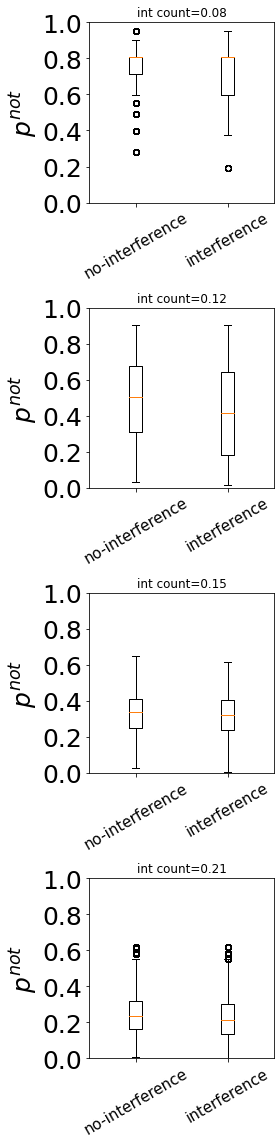

In [300]:
fig = plt.figure(figsize=(4,16))

conn_prob = 0.1
num_paths_base = 10;
num_nodes = 20;

dn = {}
for L in tqdm(range(1,5)):
    plt.subplot(4, 1, L)
    dn[L] = create_ER_deep_network(num_nodes, L, conn_prob)
    paths_set = []
    num_paths = num_paths_base*L*20
    for i in range(num_paths):
        paths_set.append(create_task_path(dn[L], np.random.randint(num_nodes)))
    interference_count = 0
    dn_interference_results = {'no-interference': [], 'interference': []}
    for cp1, cp2 in combinations(paths_set,2):
        p1, p2 = cp1[0], cp2[0];
        ds1, ds2 = cp1[1], cp2[1];
        check_int = check_task_path_interference(p1, p2);
        prob = compound_not_interference_probability(ds1, ds2, num_nodes);
        if check_int==True:
            interference_count+=1;
            dn_interference_results['interference'].append(prob);
        elif check_int==False:
            dn_interference_results['no-interference'].append(prob);
    
    plt.boxplot(dn_interference_results.values(), labels=dn_interference_results.keys());
    plt.title('int count='+str(round(interference_count/binom(num_paths,2),2)));
    plt.xticks(fontsize=15, rotation=30);
    plt.ylabel(r'$p^{not}$', fontsize=25);
    plt.yticks(fontsize=25);
    plt.ylim(0,1);
plt.tight_layout();
plt.savefig('../../white-paper/plots/multi-layer-degree-prediction.pdf')